In [1]:
from sph import *
from tqdm.notebook import trange, tqdm
%matplotlib notebook

In [33]:
pdf = lambda x: np.sin(x * np.pi * 4) + 2
# pdf = lambda x: 1 + x
# def pdf(x):
#     out = np.array(np.ones_like(x) * 2)
#     out[np.abs(x) > 1/3] = 1
#     return out
# def pdf(x):
#     x = np.array(x)
#     out = np.array(np.ones_like(x))
#     out[x > 0] = x[x>0] + 0
#     out[x < 0] = x[x<0] + 2
#     return out + 1

# pdf = lambda x: np.abs(x) + 1

# pdf = lambda x: 1 + np.exp(-(x * 8)**2) * 2
# pdf = lambda x: np.ones_like(np.array(x))
numParticles = 2048

noise  = 2 + generate1DPeriodicNoise(numSamples = numParticles, r = 0.75, freq = 4, octaves = 1, plot = False, seed = 1234) * 0.25
pdf = lambda x : np.interp(x, np.linspace(-1,1,numParticles), noise)
sampled = samplePDF(pdf, plot = False, numParticles = numParticles)

<IPython.core.display.Javascript object>


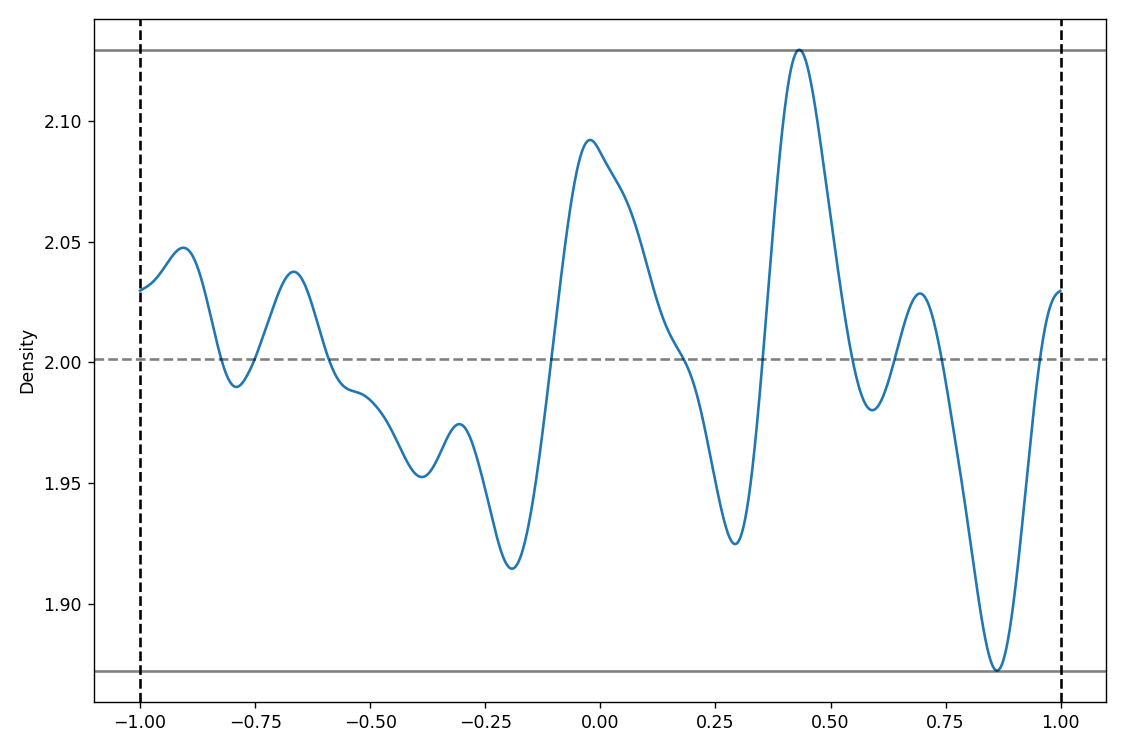

In [20]:
baseArea = 2 / numParticles * 2
particleRadius = baseArea / 2.0
particleSupport = particleRadius * 8.
xsphConstant = 0.01
kappa = 5
restDensity = 1000
dt = 1e-3

timesteps = 2048

minDomain = -1
maxDomain = 1
c0 = 10

diffusionCoefficient = 0.25


fluidPositions = ((torch.tensor(sampled)/2 +0.5)* (maxDomain - minDomain) + minDomain)
fluidVelocities = torch.zeros(fluidPositions.shape[0])
fluidAreas = torch.ones_like(fluidPositions) * baseArea
simulationStates = []

plotDensity(fluidPositions, fluidAreas, minDomain, maxDomain, particleSupport)

In [21]:
for i in tqdm(range(timesteps)):
    dudt, fluidDensity, fluidPressure = computeUpdate(fluidPositions, fluidVelocities, fluidAreas, minDomain, maxDomain, kappa, restDensity, diffusionCoefficient, particleSupport, dt)
    simulationStates.append(torch.stack([fluidPositions, fluidVelocities, fluidDensity, fluidPressure, dudt, fluidAreas]))
    
    #  8. Euler integration of velocities and positions
    fluidVelocities += dt * dudt
    fluidPositions += dt * fluidVelocities
    #  9. Enforce boundary conditions
    fluidPositions[fluidPositions < minDomain] += maxDomain - minDomain
    fluidPositions[fluidPositions > maxDomain] -= maxDomain - minDomain
    # 10. Resort data for convenience
    indices = torch.argsort(fluidPositions)
    fluidPositions = fluidPositions[indices]
    fluidVelocities = fluidVelocities[indices]
    fluidAreas = fluidAreas[indices]
# After the simulation has run we stack all the states into one large array for easier slicing and analysis
simulationStates = torch.stack(simulationStates)

  0%|          | 0/2048 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


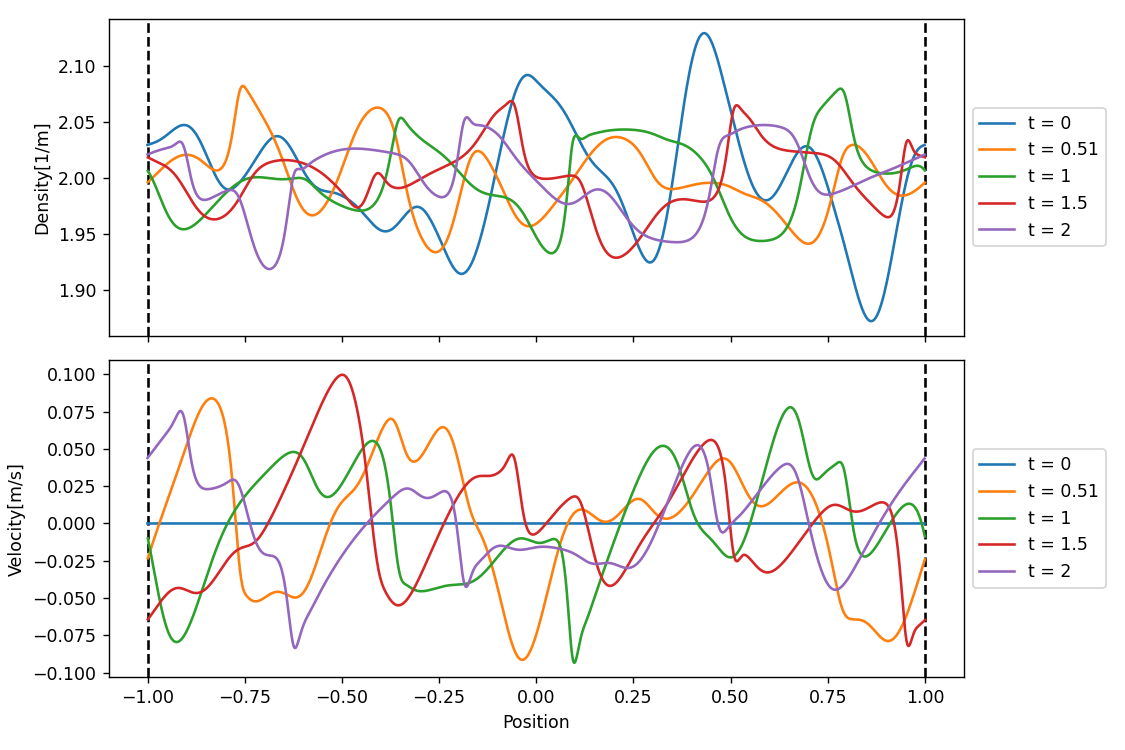

<IPython.core.display.Javascript object>


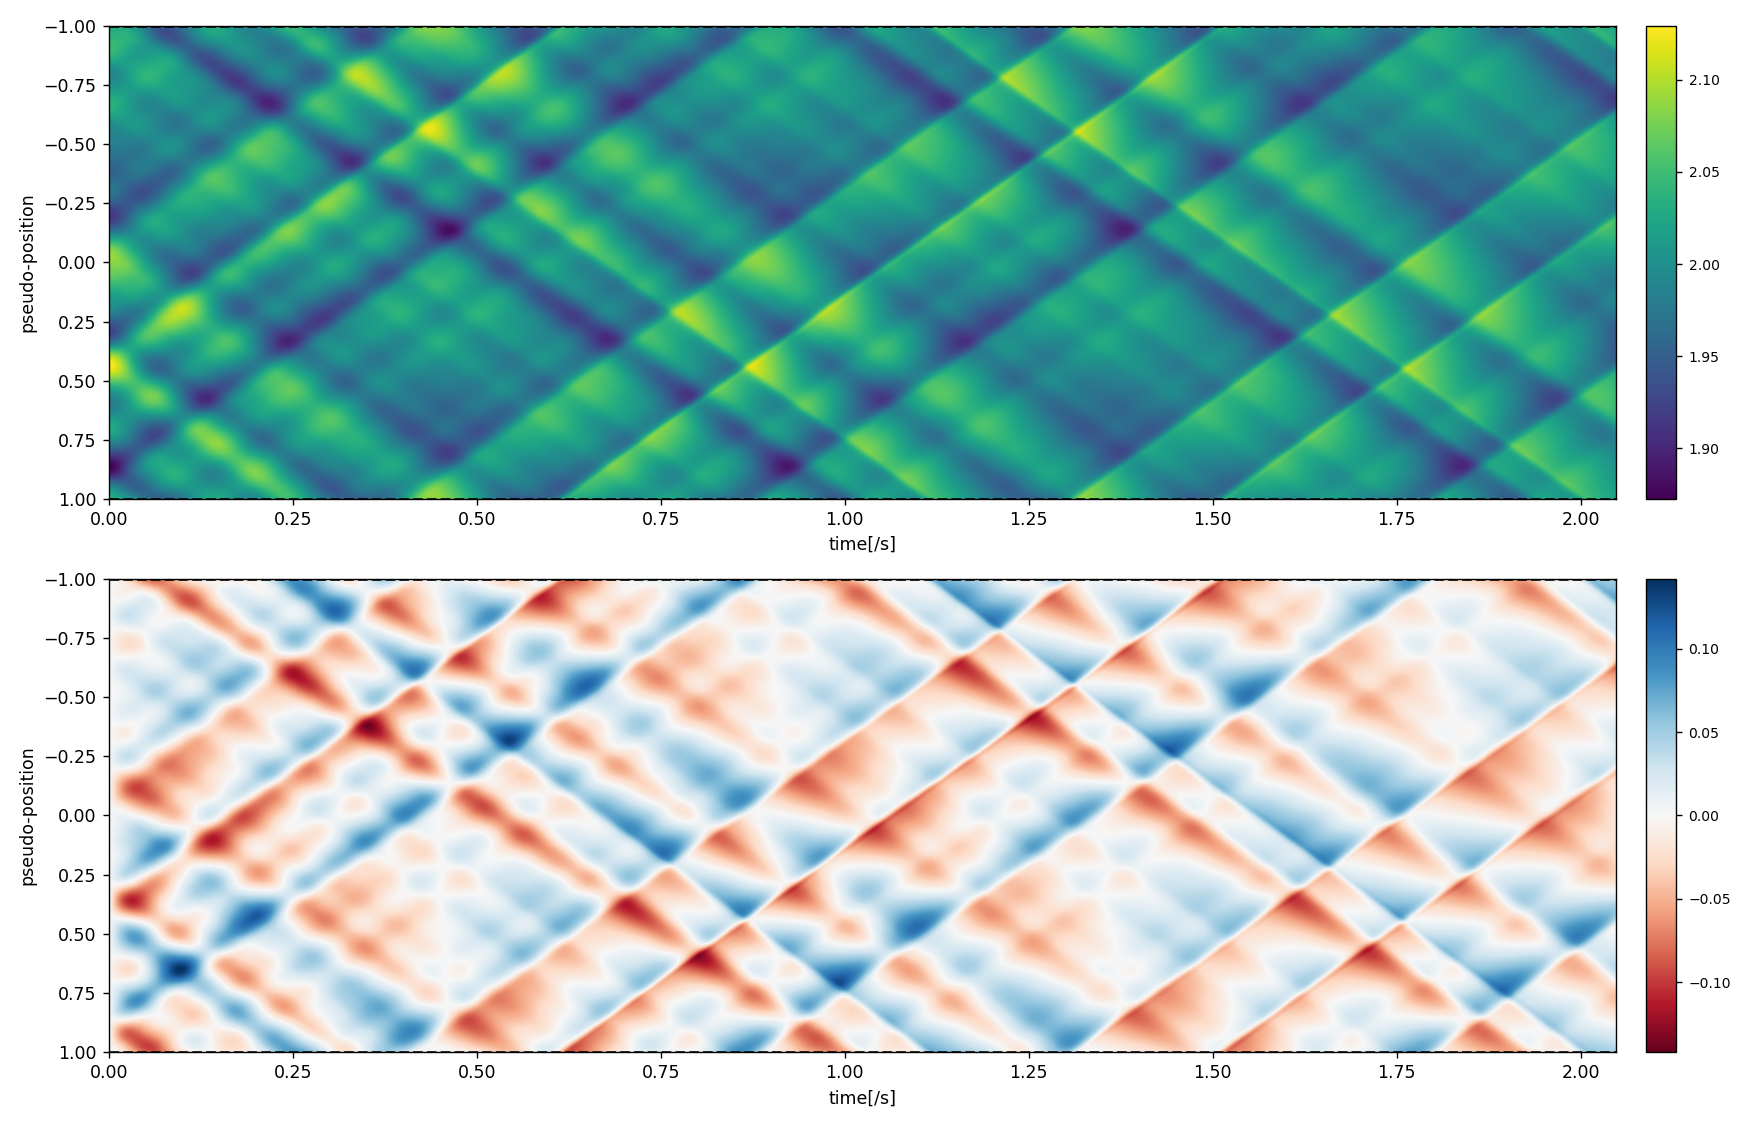

<IPython.core.display.Javascript object>


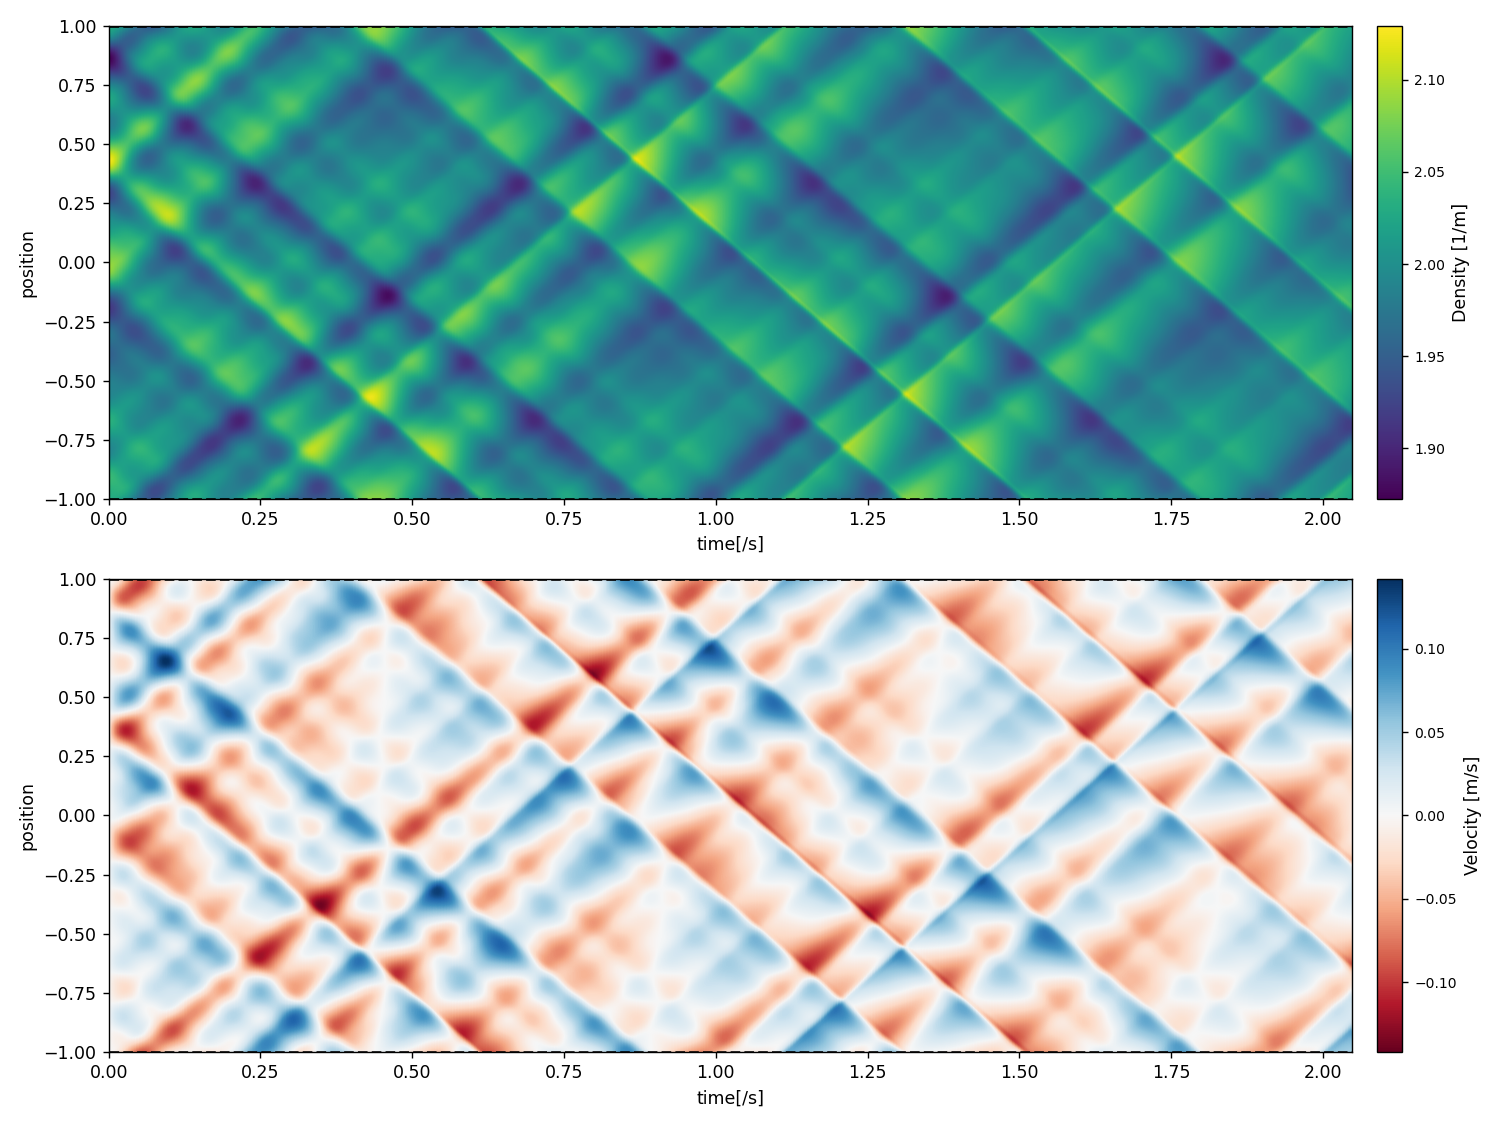

<IPython.core.display.Javascript object>


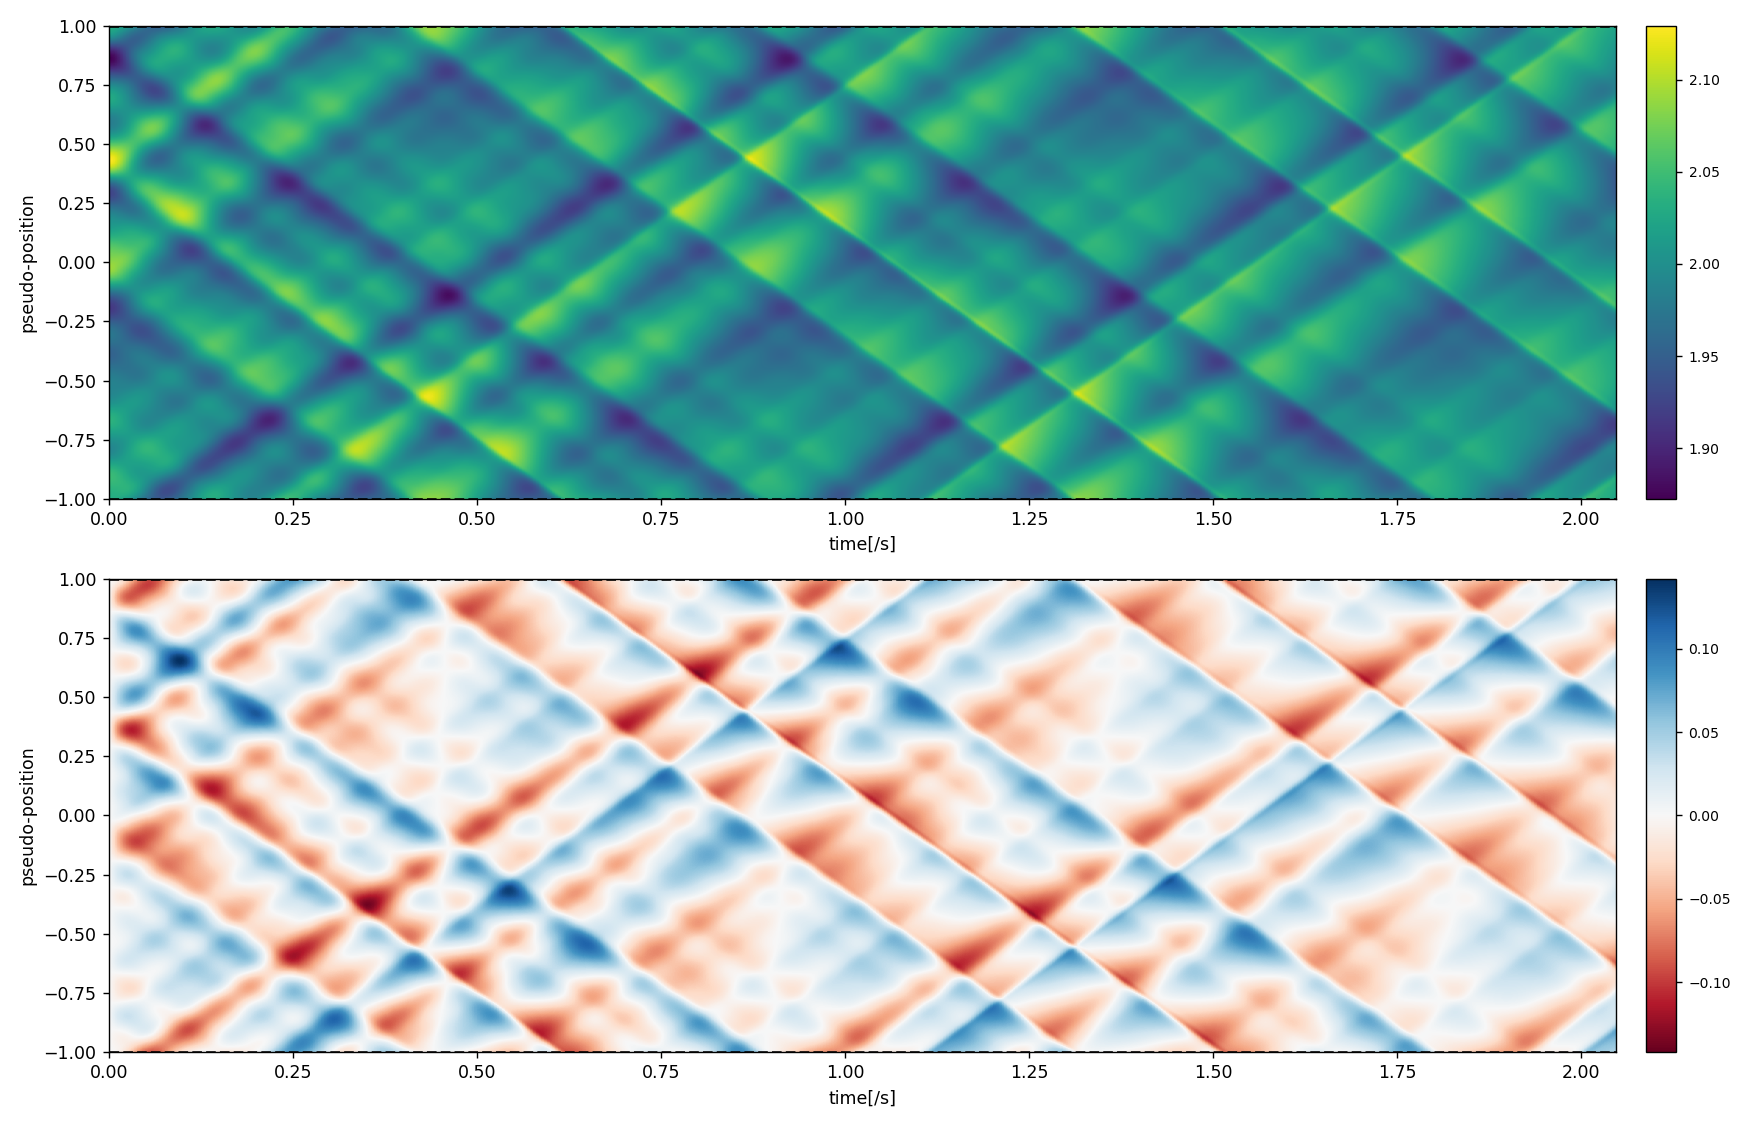

In [24]:
plotSimulationState(simulationStates, minDomain, maxDomain, dt, timepoints = [])
# plotDistorted(simulationStates, minDomain, maxDomain, dt)
# scatterPlotAll(simulationStates, minDomain, maxDomain, dt)
regularPlot(simulationStates, minDomain, maxDomain, dt, nx = numParticles, ny = timesteps)